In [1]:
!pip install tensorboard

In [2]:
import yaml
from lstm import *
from mlp import *
from gensim.models import Word2Vec
import pandas as pd
import random
#tensorboard --logdir=/home/diego/Documentos/MTG_drafter/draftsym/runs --verbosity 0

random.seed(42)

In [3]:
# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
fi = open('config.yaml', 'r')
card_dict = yaml.load(fi, Loader=yaml.FullLoader)

In [5]:
def indice_para_nome(indice, cards_dict):
    """Converte um índice para o nome da carta correspondente usando o dicionário de cartas."""
    try:
        return cards_dict['cards_list'][indice]
    except IndexError:
        raise ValueError(f"Índice {indice} fora do alcance do dicionário de cartas.")


In [6]:
df_train = pd.read_csv('train_df.csv')
df_train = df_train.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
#df_train = df_train[:90]

In [7]:
word_to_vec_model = Word2Vec.load("card2vec.model")

In [8]:
from dataset_class import *

# Crie o dataset e o DataLoader
dataset = MagicDataset(df_train, word_to_vec_model, card_dict)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Itere sobre as primeiras 45 entradas do DataLoader
for i, (inputs, labels, mascara) in enumerate(dataloader):
    if i < 45:
        print(f"--- Entrada {i+1} ---")
        
        # Converta os embeddings para nomes
        input_names = [MagicDataset.embedding_para_nome(embedding.numpy(), word_to_vec_model) for embedding in inputs.squeeze(0)]
        
        # Converta o índice da label para o nome usando a função indice_para_nome
        label_name = indice_para_nome(labels.item(), card_dict)
        print(labels.item())
        print("Inputs:", input_names)
        print("Label:", label_name)
        print("Máscara:", mascara)
        print("\n")
        break
    else:
        break


--- Entrada 1 ---
235
Inputs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Patient_Rebuilding
Máscara: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1

In [9]:
# Instanciar o modelo LSTM
from torch import nn
from mlp import *
#model = LSTMModel()
model = FeedForwardModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [11]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
from dataset_class import *
from torch.utils.data import DataLoader

# Defina os hiperparâmetros
num_epochs = 20
batch_size = 32
model_name = 'model_4'

# Configurar o TensorBoard SummaryWriter para escrever logs na pasta 'runs'
log_dir = './runs/'+model_name+'/'
writer = SummaryWriter(log_dir=log_dir)

# Defina um diretório para salvar os checkpoints
checkpoint_dir = 'checkpoints'

# Certifique-se de que o diretório exista (ou crie-o)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Criar o dataset e o DataLoader
dataset = MagicDataset(df_train, word_to_vec_model, card_dict)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Mover o modelo para a GPU
model.to(device)

# Ciclo de treinamento
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (inputs, labels, mascara) in enumerate(dataloader):
        # Mover as entradas e rótulos para a GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        mascara = mascara.to(device)

        # Zerar os gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs, mascara)
        loss = criterion(outputs, labels)
        
        # Acumular a perda
        total_loss += loss.item()

        # Backward
        loss.backward()
        optimizer.step()

        # Calcular acertos
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calcular e imprimir a perda média e a acurácia da época
    average_loss = total_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}, Epoch Acuracy: {epoch_accuracy:.4f}")

    # Registrar no TensorBoard
    writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)
    writer.add_scalar('Epoch Loss', average_loss, epoch)

    # Salvar o estado do modelo a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_loss
        }
        checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_checkpoint_epoch_{epoch + 1}.pt')
        torch.save(checkpoint, checkpoint_path)

# Fechar o writer após terminar o treinamento
writer.close()


Epoch [1/20], Average Loss: 1.3312, Epoch Acuracy: 0.5414
Epoch [2/20], Average Loss: 1.0875, Epoch Acuracy: 0.6028
Epoch [3/20], Average Loss: 1.0253, Epoch Acuracy: 0.6216
Epoch [4/20], Average Loss: 0.9978, Epoch Acuracy: 0.6303
Epoch [5/20], Average Loss: 0.9830, Epoch Acuracy: 0.6349
Epoch [6/20], Average Loss: 0.9738, Epoch Acuracy: 0.6377
Epoch [7/20], Average Loss: 0.9678, Epoch Acuracy: 0.6394
Epoch [8/20], Average Loss: 0.9636, Epoch Acuracy: 0.6404
Epoch [9/20], Average Loss: 0.9599, Epoch Acuracy: 0.6415
Epoch [10/20], Average Loss: 0.9570, Epoch Acuracy: 0.6425
Epoch [11/20], Average Loss: 0.9545, Epoch Acuracy: 0.6431
Epoch [12/20], Average Loss: 0.9524, Epoch Acuracy: 0.6436
Epoch [13/20], Average Loss: 0.9507, Epoch Acuracy: 0.6442
Epoch [14/20], Average Loss: 0.9487, Epoch Acuracy: 0.6446
Epoch [15/20], Average Loss: 0.9476, Epoch Acuracy: 0.6452
Epoch [16/20], Average Loss: 0.9457, Epoch Acuracy: 0.6456
Epoch [17/20], Average Loss: 0.9448, Epoch Acuracy: 0.6460
Epoch 

# Teste

In [1]:
import yaml
from lstm import *
from mlp import *
from gensim.models import Word2Vec
import pandas as pd

In [2]:
# Carregar o modelo e otimizador do checkpoint
def load_model_from_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


In [3]:
df_test = pd.read_csv('test_df.csv')
df_test = df_test.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [4]:
word_to_vec_model = Word2Vec.load("card2vec.model")

In [5]:
fi = open('config.yaml', 'r')
card_dict = yaml.load(fi, Loader=yaml.FullLoader)

In [7]:
# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = 'checkpoints/model_4_checkpoint_epoch_20.pt'

# Instanciar modelo e otimizador
model = FeedForwardModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Carregar o modelo do checkpoint
model, _, _, _ = load_model_from_checkpoint(model, optimizer, checkpoint_path)

In [8]:
import os
import torch
from dataset_class import *
from torch.utils.data import DataLoader

accuracy_per_round = np.zeros(45)

# Mover modelo para o dispositivo apropriado
model.to(device)
model.eval()

# Criar o dataset e o DataLoader para teste
dataset_test = MagicDataset(df_test, word_to_vec_model, card_dict)
test_loader = DataLoader(dataset_test, batch_size=45, shuffle=False)

# Variáveis para rastrear a precisão
total_samples = 0
correct_samples = 0

# Ciclo de teste
with torch.no_grad():
    for i, (inputs, labels, mascara) in enumerate(test_loader):
        # Mover entradas e rótulos para o dispositivo
        inputs = inputs.to(device)
        labels = labels.to(device)
        mascara = mascara.to(device)
        
        # Predição
        outputs = model(inputs, mascara)
        _, predicted = torch.max(outputs, 1)
        

        # Atualizar contadores de precisão
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

        # Imprimir labels e predicted
        #print("Actual Labels:", labels.tolist())
        #print("Predicted Labels:", predicted.tolist())

        for j in range(len(inputs)):
            #input_names = [MagicDataset.embedding_para_nome(embedding.cpu().numpy(), word_to_vec_model) for embedding in inputs[j]]
            #print("Input Names:", input_names)
            #print("True Label:", indice_para_nome(labels[j].item(), card_dict))
            #print("Predicted Label:", indice_para_nome(predicted[j].item(), card_dict))
            #active_indices = torch.nonzero(mascara[j]).squeeze().tolist()
            #print("Mask:", active_indices)
            #print("-------------------------------")
            if predicted[j].item() == labels[j].item():
                accuracy_per_round[j] += 1

        # Opcional: Imprimir estatísticas a cada 100 lotes
        if i % 10000 == 0:
            print(f"Batch [{i+1}/{len(test_loader)}] - Accuracy: {100 * correct_samples / total_samples:.2f}%")

        #break

# Imprimir precisão final
print(f"Total Accuracy: {100 * correct_samples / total_samples:.2f}%")

accuracy_per_round = accuracy_per_round/(len(df_test)/45)

Batch [1/21590] - Accuracy: 48.89%
Batch [10001/21590] - Accuracy: 65.31%
Batch [20001/21590] - Accuracy: 65.34%
Total Accuracy: 65.34%


In [9]:
accuracy_per_round

array([0.7       , 0.54529875, 0.53645206, 0.54478925, 0.55650764,
       0.56276054, 0.58675313, 0.59430292, 0.61051413, 0.62607689,
       0.64511348, 0.66586383, 0.69879574, 0.84367763, 1.        ,
       0.63330245, 0.59194071, 0.58193608, 0.57526633, 0.58063918,
       0.58874479, 0.59286707, 0.60856878, 0.61347846, 0.62515053,
       0.64381658, 0.66359426, 0.70046318, 0.83710051, 1.        ,
       0.63649838, 0.61093099, 0.59735989, 0.58749421, 0.58235294,
       0.59073645, 0.59416396, 0.60138953, 0.61222788, 0.61324687,
       0.63909217, 0.65974988, 0.68578045, 0.83737842, 1.        ])

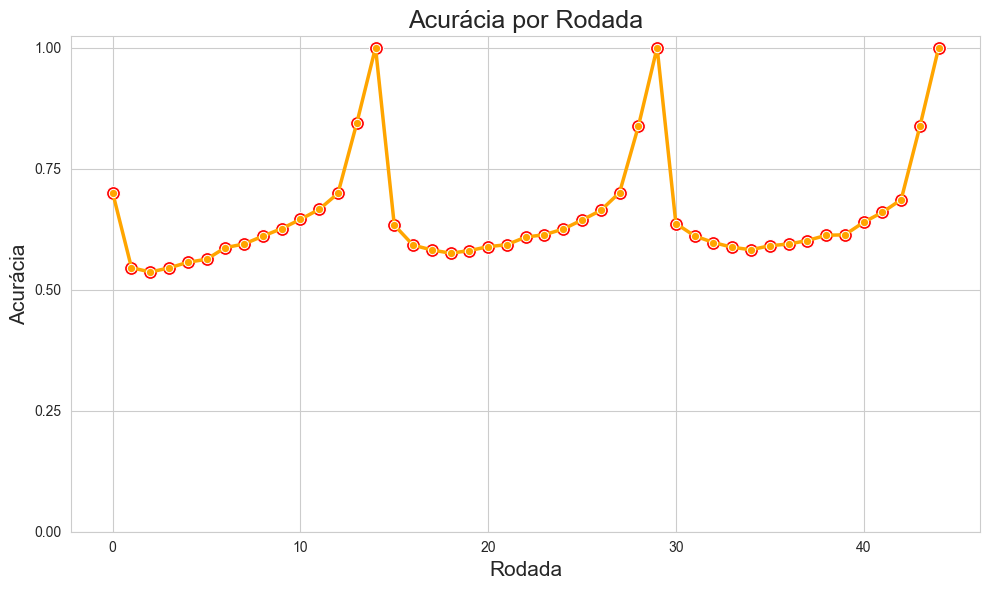

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Estilo do Seaborn
sns.set_style("whitegrid")

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando linha e pontos
sns.lineplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, linewidth=2.5, color='orange', marker='o')
sns.scatterplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, color='red', s=100)  # s define o tamanho dos pontos

# Adicionando título e rótulos
plt.title('Acurácia por Rodada', fontsize=18)
plt.xlabel('Rodada', fontsize=15)
plt.ylabel('Acurácia', fontsize=15)

# Fixando os ticks do eixo Y
plt.yticks([0, 0.25, 0.50, 0.75, 1])

plt.tight_layout()

# Exibir o gráfico
plt.show()
